# 主題模型 - LDA

套件設定

In [25]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [26]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [27]:
from matplotlib import font_manager
font_set = {f.name for f in font_manager.fontManager.ttflist}
plt.rcParams["font.sans-serif"] = ["SimHei"]

## 資料前處理

In [28]:
ptt = pd.read_csv("./rawData/avatar_ptt.csv")  # 匯資料
ptt.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/movie/M.1667292345.A.EA...,[新聞]《小美人魚》女星萬聖節扮「阿凡達」,2022-11-01 16:45:43,shengchiu303,movie,新聞網址：\nhttps://star.ettoday.net/news/2370553\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""SilentBob"", ...",59.126.128.104,2022-11-02 01:53:42,ptt
1,2,https://www.ptt.cc/bbs/movie/M.1667302786.A.20...,[討論]2023奧斯卡熱門片單(更新),2022-11-01 19:39:44,Hoult,movie,簡單整理目前獎季熱門片單評分、台灣檔期及中文預告。\n(片名後數據依序為：\n爛番茄新鮮度、...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""tools"", ""cmt...",2.58.242.132,2022-11-02 01:53:44,ptt
2,3,https://www.ptt.cc/bbs/movie/M.1667393942.A.1E...,[討論]阿凡達：水之道完整預告出爐,2022-11-02 20:59:00,yueh1001,movie,影史神作 #震撼續集《#阿凡達：#水之道》嶄新海報現身\n睽違 年重返潘朵拉星...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""yijanmou"", ""...",118.150.44.84,2022-11-03 01:53:02,ptt


In [29]:
# 看看有幾篇文章
print(f"number of posts: {ptt.shape[0]}")
print(f"date range: {(ptt['artDate'].min(), ptt['artDate'].max())}")
print(f"category: \n{ptt['artCatagory'].value_counts()}")


number of posts: 496
date range: ('2022-11-01 16:45:43', '2023-02-14 21:28:24')
category: 
artCatagory
movie    496
Name: count, dtype: int64


In [30]:
# 移除網址格式
# 只留下中文字
ptt["artContent"] = ptt["artContent"].str.replace("(http|https)://.*", "", regex=True)
ptt["artTitle"] = ptt["artTitle"].str.replace("(http|https)://.*", "", regex=True)
ptt["artContent"] = ptt["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ptt["artTitle"] = ptt["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ptt.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/movie/M.1667292345.A.EA...,新聞小美人魚女星萬聖節扮阿凡達,2022-11-01 16:45:43,shengchiu303,movie,新聞網址原標小美人魚非裔女星扮阿凡達相似度完勝小美人魚記者曾羽慧綜合報導美國女星海莉貝莉因出...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""SilentBob"", ...",59.126.128.104,2022-11-02 01:53:42,ptt
1,2,https://www.ptt.cc/bbs/movie/M.1667302786.A.20...,討論奧斯卡熱門片單更新,2022-11-01 19:39:44,Hoult,movie,簡單整理目前獎季熱門片單評分台灣檔期及中文預告片名後數據依序為爛番茄新鮮度爛番茄均分第屆奧斯...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""tools"", ""cmt...",2.58.242.132,2022-11-02 01:53:44,ptt
2,3,https://www.ptt.cc/bbs/movie/M.1667393942.A.1E...,討論阿凡達水之道完整預告出爐,2022-11-02 20:59:00,yueh1001,movie,影史神作震撼續集阿凡達水之道嶄新海報現身睽違年重返潘朵拉星球再度革新電影科技從未面世的海洋秘...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""yijanmou"", ""...",118.150.44.84,2022-11-03 01:53:02,ptt


In [31]:
# 留下 content
ptt["content"] = ptt["artTitle"] + ptt["artContent"]
ptt = ptt[["content"]]
ptt.head()

,content
0,新聞小美人魚女星萬聖節扮阿凡達新聞網址原標小美人魚非裔女星扮阿凡達相似度完勝小美人魚記者曾羽...
1,討論奧斯卡熱門片單更新簡單整理目前獎季熱門片單評分台灣檔期及中文預告片名後數據依序為爛番茄新...
2,討論阿凡達水之道完整預告出爐影史神作震撼續集阿凡達水之道嶄新海報現身睽違年重返潘朵拉星球再度...
3,新聞阿凡達正式預告曝光絕美海洋部落新聞網址阿凡達正式預告曝光絕美海洋部落歲雪歌妮薇佛以歲少女...
4,請益沒看過黑豹可以無縫觀賞黑豹嗎阿凡達已經是年的電影還創下票房第一的佳績但是我一直沒看過最近...


In [110]:
jieba.set_dictionary('./dict/dict.txt')
jieba.load_userdict('./dict/user_dict.txt')

Building prefix dict from d:\Projects\NSYSU\SocialMediaProject\project II\dict\dict.txt ...
2023-06-07 22:42:38,776 : DEBUG : Building prefix dict from d:\Projects\NSYSU\SocialMediaProject\project II\dict\dict.txt ...
Loading model from cache C:\Users\s2568\AppData\Local\Temp\jieba.ua45676c2eeaf54fc9fc93a25bce9a1ac.cache
2023-06-07 22:42:38,781 : DEBUG : Loading model from cache C:\Users\s2568\AppData\Local\Temp\jieba.ua45676c2eeaf54fc9fc93a25bce9a1ac.cache
Loading model cost 1.176 seconds.
2023-06-07 22:42:39,955 : DEBUG : Loading model cost 1.176 seconds.
Prefix dict has been built successfully.
2023-06-07 22:42:39,963 : DEBUG : Prefix dict has been built successfully.


### 從詞頻來檢視停用字清理狀況

In [111]:
ptt2 = ptt.copy()

In [112]:
word_df = ptt2.assign(word = ptt2['content'].apply(jieba.lcut)).explode('word').drop(['content'], axis=1)
word_df = word_df.loc[word_df['word'].str.len()>1]
word_df

,words,word
0,"[美人魚, 女星, 萬聖節, 扮阿凡, 原標, 美人魚, 非裔, 女星, 扮阿凡, 相似, ...",新聞
0,"[美人魚, 女星, 萬聖節, 扮阿凡, 原標, 美人魚, 非裔, 女星, 扮阿凡, 相似, ...",美人魚
0,"[美人魚, 女星, 萬聖節, 扮阿凡, 原標, 美人魚, 非裔, 女星, 扮阿凡, 相似, ...",女星
0,"[美人魚, 女星, 萬聖節, 扮阿凡, 原標, 美人魚, 非裔, 女星, 扮阿凡, 相似, ...",萬聖節
0,"[美人魚, 女星, 萬聖節, 扮阿凡, 原標, 美人魚, 非裔, 女星, 扮阿凡, 相似, ...",阿凡達
...,...,...
495,"[好雷, 巴比倫, 巴比倫, 講述, 年代, 好萊塢, 有聲電影, 崛起, 無聲電影, 演員...",希望
495,"[好雷, 巴比倫, 巴比倫, 講述, 年代, 好萊塢, 有聲電影, 崛起, 無聲電影, 演員...",這部
495,"[好雷, 巴比倫, 巴比倫, 講述, 年代, 好萊塢, 有聲電影, 崛起, 無聲電影, 演員...",評價
495,"[好雷, 巴比倫, 巴比倫, 講述, 年代, 好萊塢, 有聲電影, 崛起, 無聲電影, 演員...",受到


In [113]:
# 以檔案形式匯入通用的停用字檔案
stopwords = [line.strip() for line in open('./dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 
noStop_df = word_df[~word_df['word'].isin(stopwords)]
noStop_df

,words,word
0,"[美人魚, 女星, 萬聖節, 扮阿凡, 原標, 美人魚, 非裔, 女星, 扮阿凡, 相似, ...",新聞
0,"[美人魚, 女星, 萬聖節, 扮阿凡, 原標, 美人魚, 非裔, 女星, 扮阿凡, 相似, ...",美人魚
0,"[美人魚, 女星, 萬聖節, 扮阿凡, 原標, 美人魚, 非裔, 女星, 扮阿凡, 相似, ...",女星
0,"[美人魚, 女星, 萬聖節, 扮阿凡, 原標, 美人魚, 非裔, 女星, 扮阿凡, 相似, ...",萬聖節
0,"[美人魚, 女星, 萬聖節, 扮阿凡, 原標, 美人魚, 非裔, 女星, 扮阿凡, 相似, ...",阿凡達
...,...,...
495,"[好雷, 巴比倫, 巴比倫, 講述, 年代, 好萊塢, 有聲電影, 崛起, 無聲電影, 演員...",原意
495,"[好雷, 巴比倫, 巴比倫, 講述, 年代, 好萊塢, 有聲電影, 崛起, 無聲電影, 演員...",希望
495,"[好雷, 巴比倫, 巴比倫, 講述, 年代, 好萊塢, 有聲電影, 崛起, 無聲電影, 演員...",這部
495,"[好雷, 巴比倫, 巴比倫, 講述, 年代, 好萊塢, 有聲電影, 崛起, 無聲電影, 演員...",評價


In [114]:
freq_df = pd.DataFrame({'freq':noStop_df.groupby(['word']).size().sort_values(ascending=False)}).reset_index(drop = False)

clist = ['word','freq']
freq_df = freq_df[clist]
freq_df

,word,freq
0,阿凡達,1468
1,電影,971
2,最佳,931
3,票房,793
4,水之道,673
...,...,...
15044,拳拳,1
15045,拳腳,1
15046,拼圖,1
15047,拿手,1


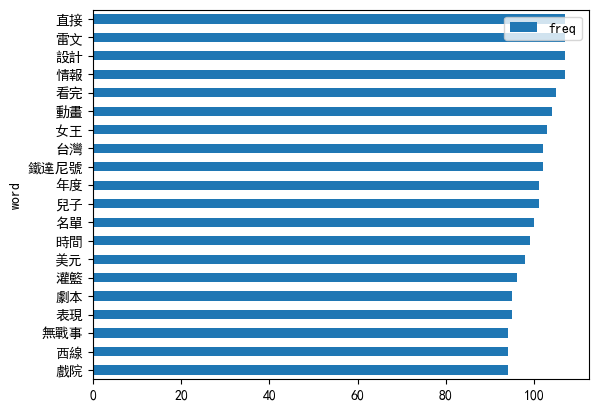

In [115]:
freq_df.iloc[80:100].plot.barh(x='word', y='freq').invert_yaxis()
plt.show()

#### 正式處理資料集

In [116]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")


stopwords_manual = ['媽的', '順位', '知道', '畫面', '看到', '新聞', '抽絲剝繭', 
                    '起義', '討論', '感覺', '這部', '完全', '成為', '之後',
                    '一下', '日麗', '今年', '目前', '部分', '直接', '雷文', '看完',
                    '時間', '美元', '請益', '看過', '第名', '網址', '億美元', '萬美元', '億萬']
# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]
stopWords.extend(stopwords_manual)

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

ptt["words"] = ptt["content"].apply(getToken)
ptt

Building prefix dict from d:\Projects\NSYSU\SocialMediaProject\project II\dict\dict.txt.big ...
2023-06-07 22:42:43,553 : DEBUG : Building prefix dict from d:\Projects\NSYSU\SocialMediaProject\project II\dict\dict.txt.big ...
Loading model from cache C:\Users\s2568\AppData\Local\Temp\jieba.ud92a21fb1477a88e930439c2ae487cf8.cache
2023-06-07 22:42:43,553 : DEBUG : Loading model from cache C:\Users\s2568\AppData\Local\Temp\jieba.ud92a21fb1477a88e930439c2ae487cf8.cache
Loading model cost 3.464 seconds.
2023-06-07 22:42:47,017 : DEBUG : Loading model cost 3.464 seconds.
Prefix dict has been built successfully.
2023-06-07 22:42:47,017 : DEBUG : Prefix dict has been built successfully.


,content,words
0,新聞小美人魚女星萬聖節扮阿凡達新聞網址原標小美人魚非裔女星扮阿凡達相似度完勝小美人魚記者曾羽...,"[美人魚, 女星, 萬聖節, 扮阿凡, 原標, 美人魚, 非裔, 女星, 扮阿凡, 相似, ..."
1,討論奧斯卡熱門片單更新簡單整理目前獎季熱門片單評分台灣檔期及中文預告片名後數據依序為爛番茄新...,"[奧斯卡, 熱門, 片單, 更新, 簡單, 整理, 獎季, 熱門, 片單, 評分, 台灣, ..."
2,討論阿凡達水之道完整預告出爐影史神作震撼續集阿凡達水之道嶄新海報現身睽違年重返潘朵拉星球再度...,"[阿凡達, 水之道, 完整, 預告, 出爐, 影史, 神作, 震撼, 續集, 阿凡達, 水之..."
3,新聞阿凡達正式預告曝光絕美海洋部落新聞網址阿凡達正式預告曝光絕美海洋部落歲雪歌妮薇佛以歲少女...,"[阿凡, 正式, 預告, 曝光, 絕美, 海洋, 部落, 阿凡, 正式, 預告, 曝光, 絕..."
4,請益沒看過黑豹可以無縫觀賞黑豹嗎阿凡達已經是年的電影還創下票房第一的佳績但是我一直沒看過最近...,"[黑豹, 無縫, 觀賞, 黑豹, 阿凡, 電影, 創下, 票房, 佳績, 一直, 最近, 電..."
...,...,...
491,新聞阿凡達水之道即將擠下鐵達尼號新聞網址阿凡達水之道擠下鐵達尼號站上影史賣座前三名記者蕭采薇...,"[阿凡達, 水之道, 擠下, 鐵達尼, 阿凡達, 水之道, 擠下, 鐵達尼, 站上, 影史,..."
492,情報黑膠卷獎得獎名單女王女王提爾純真之死黑豹瓦干達萬歲橋之彼端女王女王阿凡達水之道提爾純真之...,"[情報, 黑膠, 卷獎, 得獎, 名單, 女王, 女王, 提爾, 純真, 之死, 黑豹, 瓦..."
493,情報阿凡達全球票房突破億截至北美票房海外票房全球累計本週阿凡達北美票房排名第二原本預期阿凡達...,"[情報, 阿凡, 全球, 票房, 突破, 北美票房, 海外, 票房, 全球, 累計, 本週,..."
494,神雷鐵達尼號沒拿到海報就只能跟牆壁合照我以為短時間不會重回美麗華結果鐵達尼號的呼喚讓我一回過...,"[神雷, 鐵達尼, 沒拿到, 海報, 只能, 牆壁, 合照, 短時間, 重回, 美麗, 鐵達..."


## LDA 主題模型

In [117]:
docs = ptt['words'].to_list()

In [118]:
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2023-06-07 22:43:04,332 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2023-06-07 22:43:04,672 : INFO : built Dictionary<15459 unique tokens: ['一天', '一直', '上映', '不符', '不適']...> from 496 documents (total 73636 corpus positions)
2023-06-07 22:43:04,674 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<15459 unique tokens: ['一天', '一直', '上映', '不符', '不適']...> from 496 documents (total 73636 corpus positions)", 'datetime': '2023-06-07T22:43:04.674199', 'gensim': '4.3.1', 'python': '3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'created'}
2023-06-07 22:43:04,733 : INFO : discarding 13342 tokens: [('不符', 2), ('不適', 3), ('並對', 1), ('人心', 4), ('仙氣', 1), ('任此', 1), ('出演', 2), ('原標', 1), ('原角', 1), ('反對', 2)]...
2023-06-07 22:43:04,740 : INFO : keeping 2117 tokens which were in no less than 5 and no more than 491 (=99.0%) documents
2023-06-07 22:43:04,765 : INFO : resulting dictionary

Dictionary<2117 unique tokens: ['一天', '一直', '上映', '主角', '依舊']...>


In [119]:
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

corpus[0][:3]

[(0, 1), (1, 1), (2, 1)]

#### 建立模型
**透過指標找出最佳主題數**


透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數。<br>
這裡以 perplexity 為指標，因為gensim套件的問題，我們將其進行轉換。<br>


In [141]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 2048,
        alpha=0.1,
        eta=0.3,
        iterations=5000,
        passes=10 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

2023-06-07 23:31:54,127 : INFO : using serial LDA version on this node
2023-06-07 23:31:54,129 : INFO : running online (multi-pass) LDA training, 2 topics, 10 passes over the supplied corpus of 496 documents, updating model once every 496 documents, evaluating perplexity every 496 documents, iterating 5000x with a convergence threshold of 0.001000
2023-06-07 23:31:55,734 : INFO : -8.136 per-word bound, 281.3 perplexity estimate based on a held-out corpus of 496 documents with 51461 words
2023-06-07 23:31:55,735 : INFO : PROGRESS: pass 0, at document #496/496
2023-06-07 23:31:57,078 : INFO : topic #0 (0.100): 0.028*"最佳" + 0.020*"電影" + 0.017*"阿凡" + 0.014*"宇宙" + 0.013*"多重" + 0.013*"票房" + 0.013*"阿凡達" + 0.013*"水之道" + 0.008*"捍衛戰士" + 0.007*"伊尼舍林"
2023-06-07 23:31:57,079 : INFO : topic #1 (0.100): 0.015*"票房" + 0.014*"電影" + 0.011*"阿凡" + 0.010*"水之道" + 0.010*"阿凡達" + 0.009*"劇情" + 0.009*"人類" + 0.008*"宇宙" + 0.008*"多重" + 0.007*"最後"
2023-06-07 23:31:57,081 : INFO : topic diff=0.845347, rho=1.000000
20

花費時間: 99.27371835708618 sec


In [121]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,793.179741,0.042462
1,3,667.554494,0.111629
2,4,662.296808,0.101633
3,5,652.051258,0.076574
4,6,650.918067,0.064407
5,7,658.895448,0.040374
6,8,669.568295,-0.009231
7,9,678.021345,0.037061


<Axes: xlabel='topic_num'>

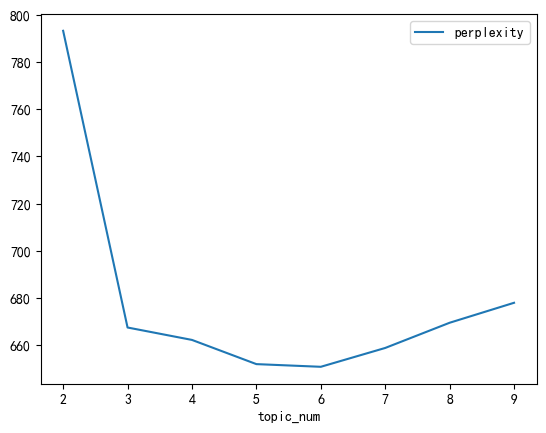

In [122]:
result.plot.line(x='topic_num', y='perplexity')

<Axes: xlabel='topic_num'>

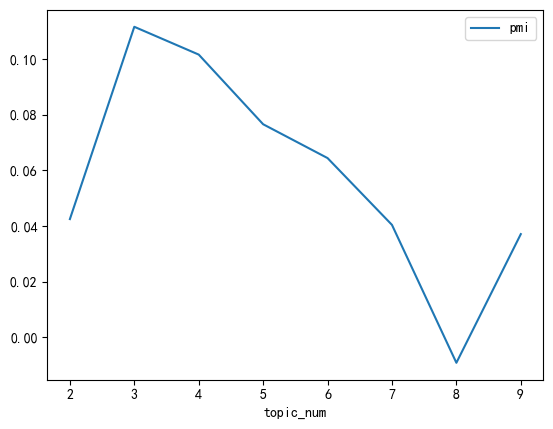

In [123]:
result.plot.line(x='topic_num', y='pmi')

## 視覺化呈現

In [142]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 3,
    id2word=dictionary,
    random_state = 2048,
    alpha=0.1,
    eta=0.3,
    iterations=5000,
    passes=10 # 訓練次數
    )

2023-06-07 23:35:34,326 : INFO : using serial LDA version on this node
2023-06-07 23:35:34,328 : INFO : running online (multi-pass) LDA training, 3 topics, 10 passes over the supplied corpus of 496 documents, updating model once every 496 documents, evaluating perplexity every 496 documents, iterating 5000x with a convergence threshold of 0.001000
2023-06-07 23:35:36,046 : INFO : -8.162 per-word bound, 286.4 perplexity estimate based on a held-out corpus of 496 documents with 51461 words
2023-06-07 23:35:36,049 : INFO : PROGRESS: pass 0, at document #496/496
2023-06-07 23:35:37,711 : INFO : topic #0 (0.100): 0.034*"最佳" + 0.019*"電影" + 0.017*"宇宙" + 0.016*"多重" + 0.016*"阿凡" + 0.014*"票房" + 0.014*"阿凡達" + 0.014*"水之道" + 0.009*"捍衛戰士" + 0.009*"伊尼舍林"
2023-06-07 23:35:37,712 : INFO : topic #1 (0.100): 0.017*"票房" + 0.014*"電影" + 0.012*"水之道" + 0.012*"阿凡達" + 0.011*"宇宙" + 0.010*"阿凡" + 0.010*"多重" + 0.009*"人類" + 0.007*"劇情" + 0.007*"上映"
2023-06-07 23:35:37,712 : INFO : topic #2 (0.100): 0.017*"電影" + 0.016

In [143]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.207093  0.118249       1        1  50.846068
1     -0.067318 -0.166616       2        1  25.647788
0      0.274411  0.048367       3        1  23.506144, topic_info=      Term        Freq       Total Category  logprob  loglift
604     最佳  789.000000  789.000000  Default  30.0000  30.0000
215     票房  732.000000  732.000000  Default  29.0000  29.0000
78      多重  528.000000  528.000000  Default  28.0000  28.0000
85      宇宙  552.000000  552.000000  Default  27.0000  27.0000
62    伊尼舍林  292.000000  292.000000  Default  26.0000  26.0000
...    ...         ...         ...      ...      ...      ...
1345    老爸   92.693606  109.890781   Topic3  -4.8714   1.2777
140     黑豹  143.162698  226.122814   Topic3  -4.4367   0.9908
135    阿凡達  171.166647  588.001515   Topic3  -4.2580   0.2138
105    水之道  151.109461  597.880099   Topic3  -4.3827   0.0725
628     鯨魚   94.311828  159.456307   Topic3  -4.8541   0.9227

[213 rows x 6 columns], token_table=      Topic      Freq Term
term                      
2         1  0.110997   上映
2         2  0.837526   上映
2         3  0.050453   上映
1395      1  0.991817   上校
1395      2  0.006011   上校
...     ...       ...  ...
628       2  0.006271   鯨魚
628       3  0.589503   鯨魚
140       1  0.022112   黑豹
140       2  0.344945   黑豹
140       3  0.632400   黑豹

[382 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [144]:
pyLDAvis.save_html(p, "lda_zh.html")